In [1]:
import random

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from utils.training import data_loading
from utils.training.data_loading import lines_to_line_generator, get_line_to_spectro_seg, csv_to_lines
from utils.training.models import time_segmenter_model

2023-10-25 15:35:20.174342: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 15:35:20.310814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 15:35:20.310840: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 15:35:20.311719: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 15:35:20.386602: I tensorflow/core/platform/cpu_feature_g

In [2]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/training/spectrograms"
SEED = 0
BATCH_SIZE = 64
EPOCHS = 50
CHECKPOINTS_DIR = "checkpoints_seg"

SIZE = (128, 128)  # number of pixels in the spectrograms
CHANNELS = 1  # 1 means grayscale 3 RGB
DURATION_S = 200  # duration of the spectrograms in s
GAUSSIAN_STDVAR_S = 10  # defines dispersion of objective function

data_loader = get_line_to_spectro_seg(size=SIZE, duration_s=DURATION_S, channels=CHANNELS, gaussian_stdvar_s=GAUSSIAN_STDVAR_S)
model = time_segmenter_model()

2023-10-25 15:35:23.202592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 15:35:23.278992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 15:35:23.279158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
pos, neg = csv_to_lines(f"{ROOT_DIR}/dataset.csv")
lines = pos + neg
print(len(lines), "files found")

random.Random(SEED).shuffle(lines)
train_lines = lines[int(0.2 * len(lines)):]
valid_lines = lines[:int(0.2 * len(lines))]

train_generator = lines_to_line_generator(train_lines)
valid_generator = lines_to_line_generator(valid_lines)

train_dataset = tf.data.Dataset.from_generator(lambda: map(tuple, train_generator), output_signature=tf.TensorSpec(shape=[None], dtype=tf.string))
valid_dataset = tf.data.Dataset.from_generator(lambda: map(tuple, valid_generator), output_signature=tf.TensorSpec(shape=[None], dtype=tf.string))

train_dataset = train_dataset.map(data_loader).batch(batch_size=BATCH_SIZE)
valid_dataset = valid_dataset.map(data_loader).batch(batch_size=BATCH_SIZE)

26902 files found


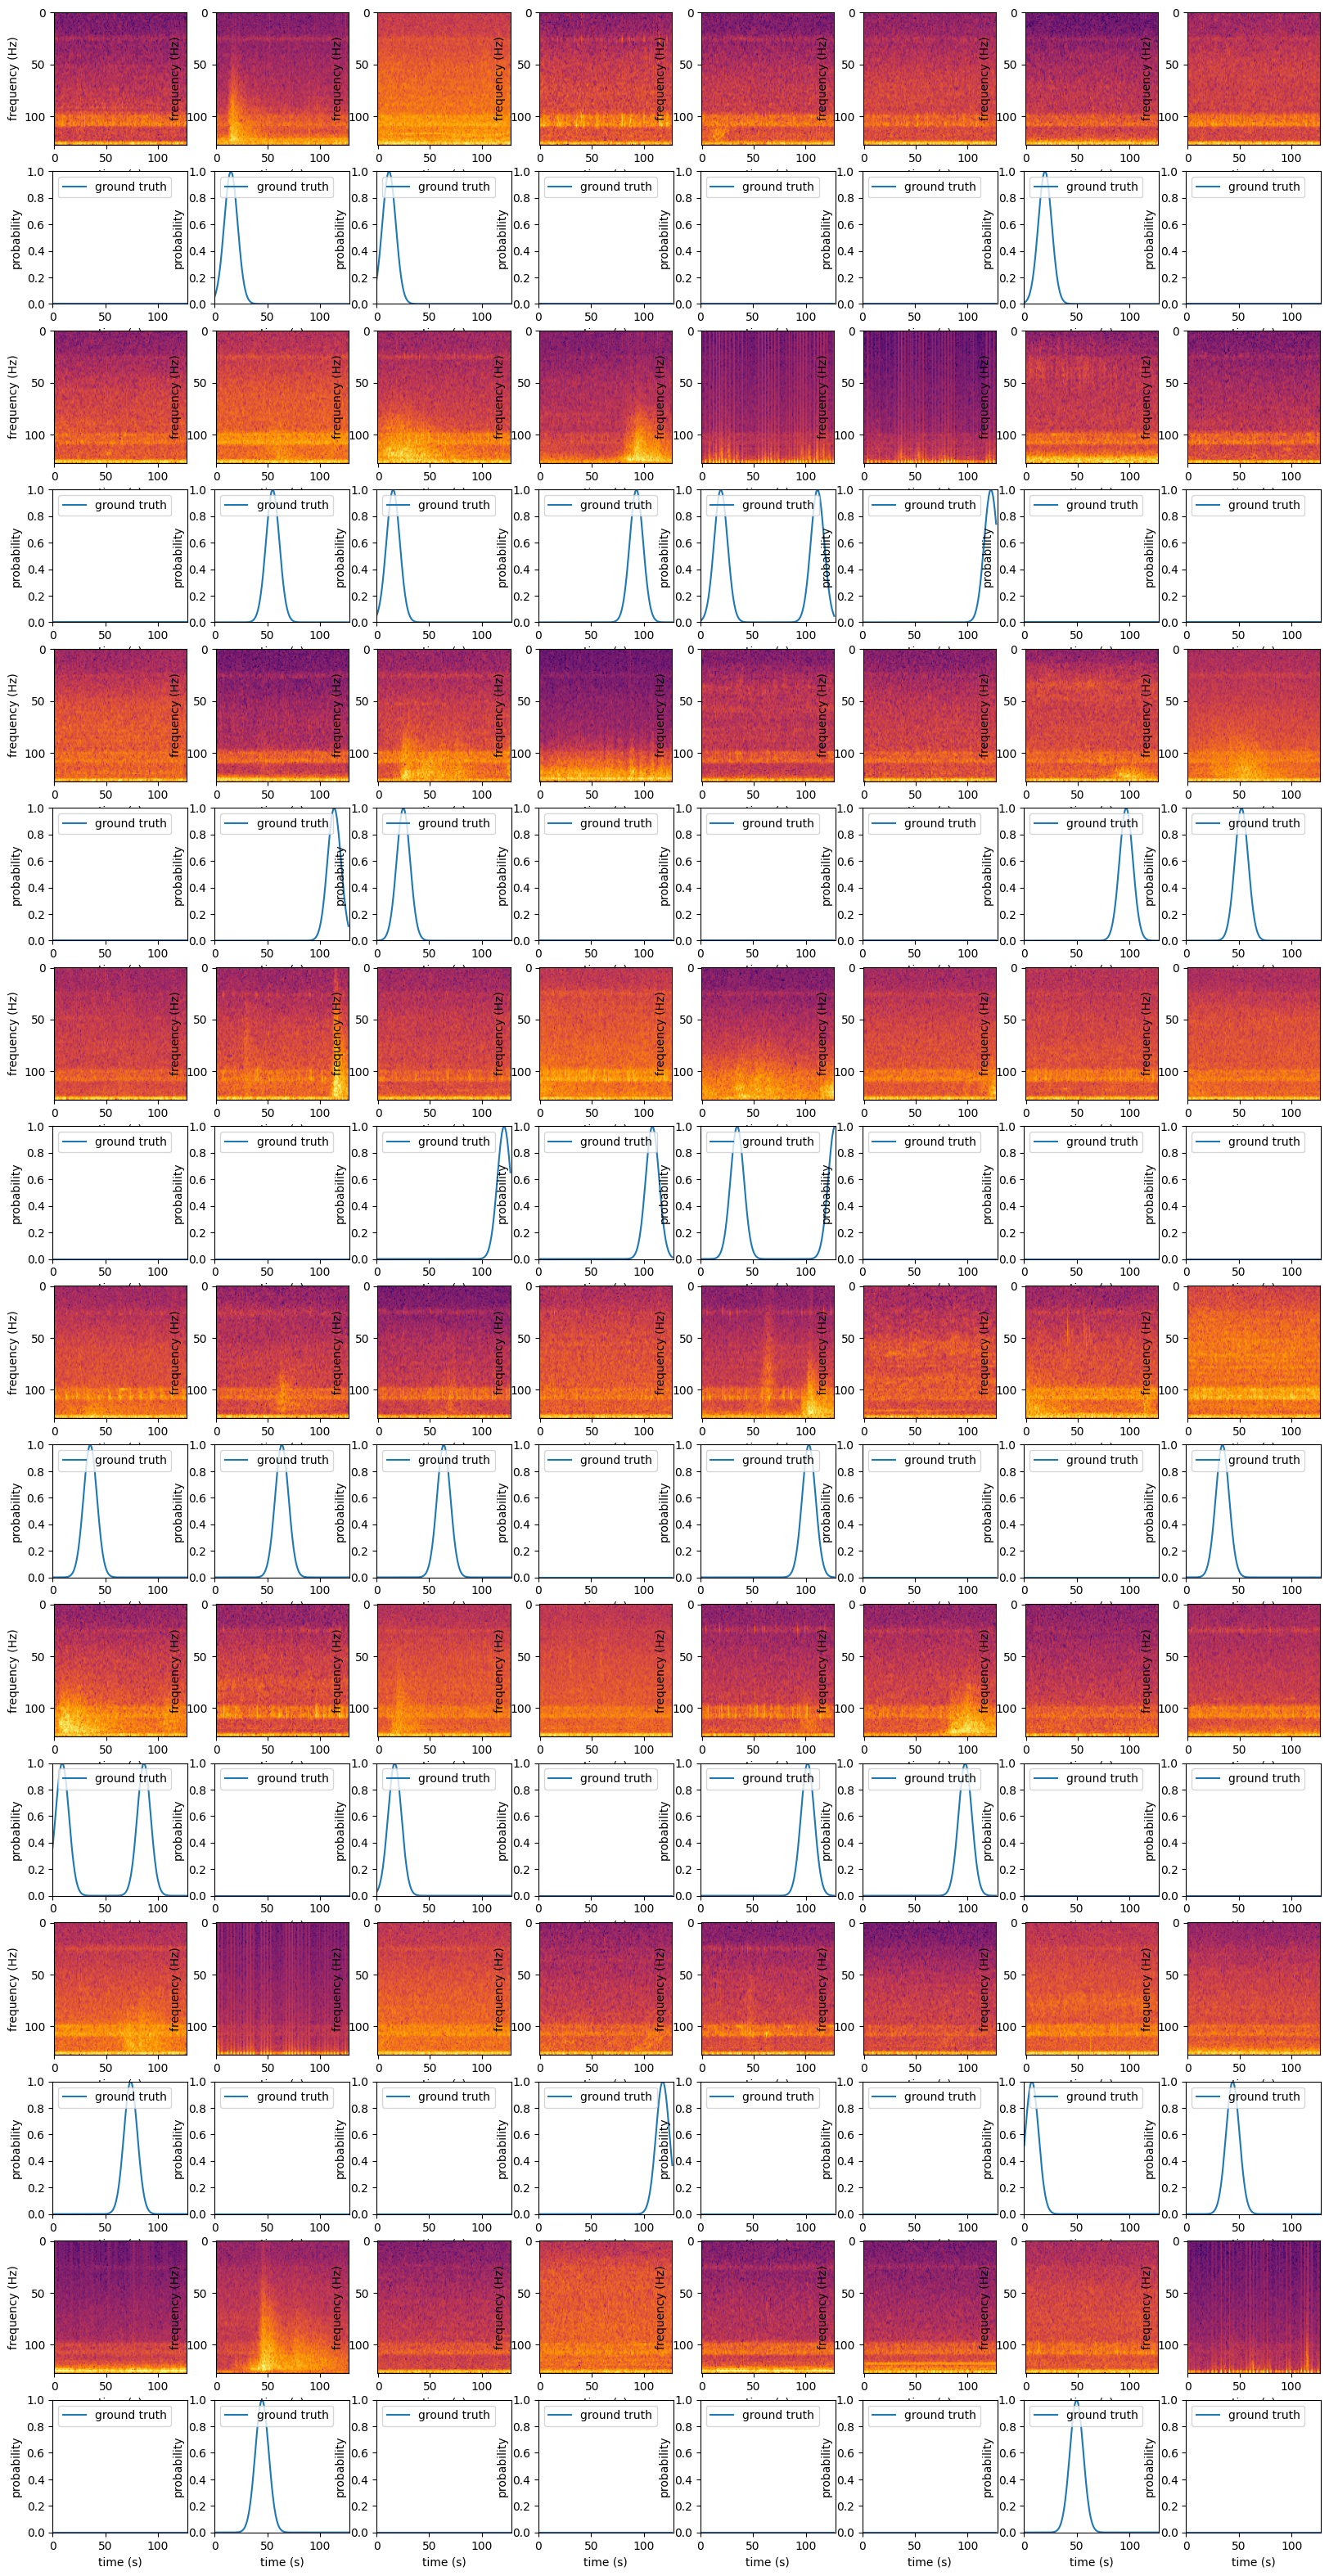

In [4]:
cols = 8
lines = 8
batch_number = 1  # number of the batch we want to inspect

to_show = cols * lines
plt.figure(figsize=(20, lines*5))
shown=0
for images, y in valid_dataset.take(batch_number+to_show//BATCH_SIZE+1):
    if batch_number:
            batch_number -= 1
            continue
    for i in range(min(BATCH_SIZE, to_show-shown)):
        ax1 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols))
        plt.xlabel("time (s)")
        plt.ylabel("frequency (Hz)")
        plt.imshow(images[i].numpy(), cmap='inferno')

        ax2 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols) + cols)

        ax2.plot(y[i], label='ground truth')
        ax2.legend(loc="upper left")
        ax2.set_xlim([0, SIZE[0]])
        ax2.set_ylim([0, 1])
        ax2.set_xlabel("time (s)")
        ax2.set_ylabel("probability")

        shown += 1
plt.show()

In [5]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.losses.binary_crossentropy,
        metrics='MeanAbsoluteError')

model.build((BATCH_SIZE, SIZE[0], SIZE[1], 1))

model.summary()

Model: "time_segmenter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 1)     0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 16)    1040      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    16400     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    16400     
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 16)    0         
 D)                                                              
                                                    

In [8]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{CHECKPOINTS_DIR}/cp-{{epoch:04d}}.ckpt",
                                                     save_weights_only=True,
                                                     verbose=1)

In [9]:
model.fit(
        train_dataset,
        batch_size=BATCH_SIZE,
        validation_data=valid_dataset,
        steps_per_epoch=len(train_lines) // BATCH_SIZE,
        validation_steps=len(valid_lines) // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[cp_callback]
    )

Epoch 1/50
336/336 [==============================] - ETA: 0s - loss: 0.2409 - mean_absolute_error: 0.1130
Epoch 1: saving model to checkpoints_seg/cp-0001.ckpt
336/336 [==============================] - 166s 495ms/step - loss: 0.2409 - mean_absolute_error: 0.1130 - val_loss: 0.2322 - val_mean_absolute_error: 0.1001
Epoch 2/50
336/336 [==============================] - ETA: 0s - loss: 0.2256 - mean_absolute_error: 0.1050
Epoch 2: saving model to checkpoints_seg/cp-0002.ckpt
336/336 [==============================] - 167s 497ms/step - loss: 0.2256 - mean_absolute_error: 0.1050 - val_loss: 0.2095 - val_mean_absolute_error: 0.0898
Epoch 3/50
336/336 [==============================] - ETA: 0s - loss: 0.2111 - mean_absolute_error: 0.0959
Epoch 3: saving model to checkpoints_seg/cp-0003.ckpt
336/336 [==============================] - 168s 500ms/step - loss: 0.2111 - mean_absolute_error: 0.0959 - val_loss: 0.2040 - val_mean_absolute_error: 0.0870
Epoch 4/50
336/336 [==========================

In [10]:
model.load_weights(f"{CHECKPOINTS_DIR}/cp-0040.ckpt")

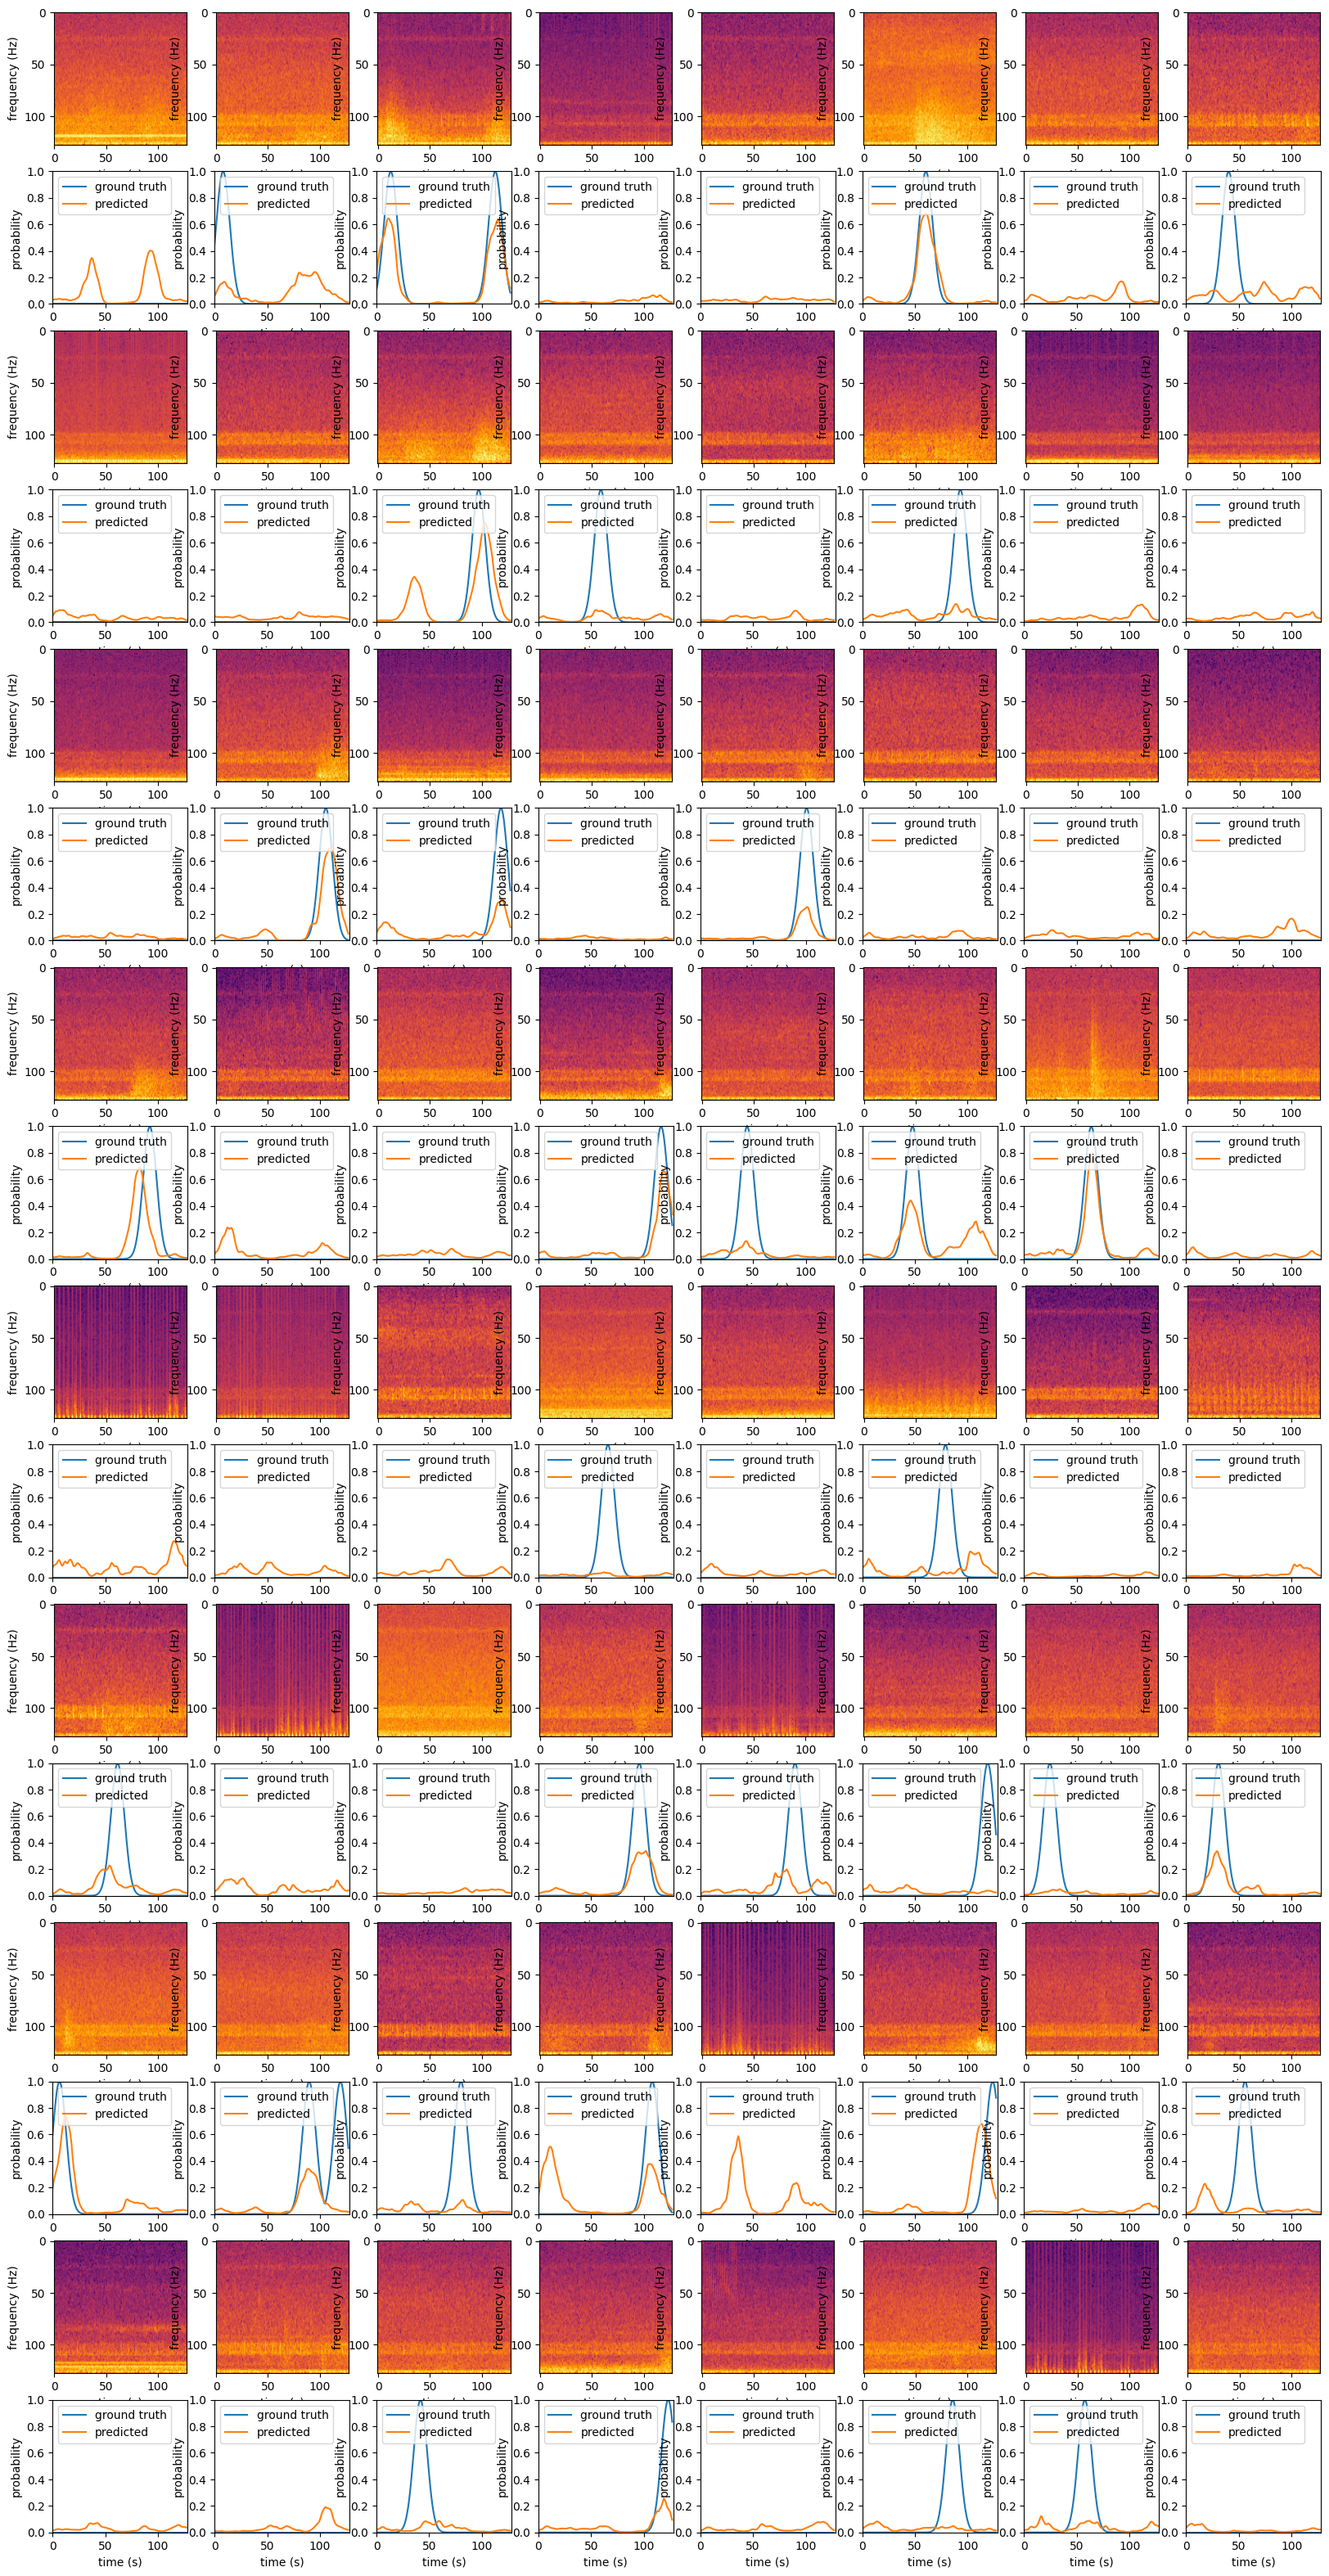

In [12]:
cols = 8
lines = 8
batch_number = 1

to_show = cols * lines
plt.figure(figsize=(20, lines*5))
shown=0
for images, y in valid_dataset.take(batch_number+to_show//BATCH_SIZE+1):
    if batch_number:
            batch_number -= 1
            continue
    for i in range(min(BATCH_SIZE, to_show-shown)):
        ax1 = plt.subplot(lines*2, cols, 1 + i%cols + cols*2*(i//cols))
        plt.xlabel("time (s)")
        plt.ylabel("frequency (Hz)")
        plt.imshow(images[i].numpy(), cmap='inferno')

        ax2 = plt.subplot(lines*2, cols, 1 + i%cols + cols*2*(i//cols) + cols)
        
        ax2.plot(y[i], label='ground truth')
        predicted = model.predict(np.reshape(images[i], (1, 128, 128, 1)), verbose=False)[0]
        ax2.plot(predicted, label='predicted')
        ax2.legend(loc="upper left")
        ax2.set_xlim([0, 128])
        ax2.set_ylim([0, 1])
        ax2.set_xlabel("time (s)")
        ax2.set_ylabel("probability")

        shown += 1
plt.show()